<a href="https://colab.research.google.com/github/imane-belbachir/ALGO-SORTS/blob/main/temperatureanomalies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Upload your Sensors_data.csv file

Step 2: Exploring and preprocessing the data

Dataset information:
Number of rows: 385872
Number of columns: 5

First few rows of the dataset:
   Unnamed: 0                 _time  Heat_index   Humidity  Temperature
0           0  2022-04-13T21:38:00Z   26.389790  32.400000    26.800000
1           1  2022-04-13T21:39:00Z   26.391128  32.433333    26.800000
2           2  2022-04-13T21:40:00Z   26.377855  32.100000    26.800000
3           3  2022-04-13T21:41:00Z   26.401618  31.916667    26.850000
4           4  2022-04-13T21:42:00Z   26.414282  31.716667    26.883333

Missing values in each column:
Unnamed: 0     0
_time          0
Heat_index     0
Humidity       0
Temperature    0
dtype: int64

Step 3: Creating a model for solar energy prediction

Synthetic solar energy output statistics:
count    385872.000000
mean          1.311986
std           1.602791
min           0.000000
25%           0.000000
50%           0.000000
75%           2.9

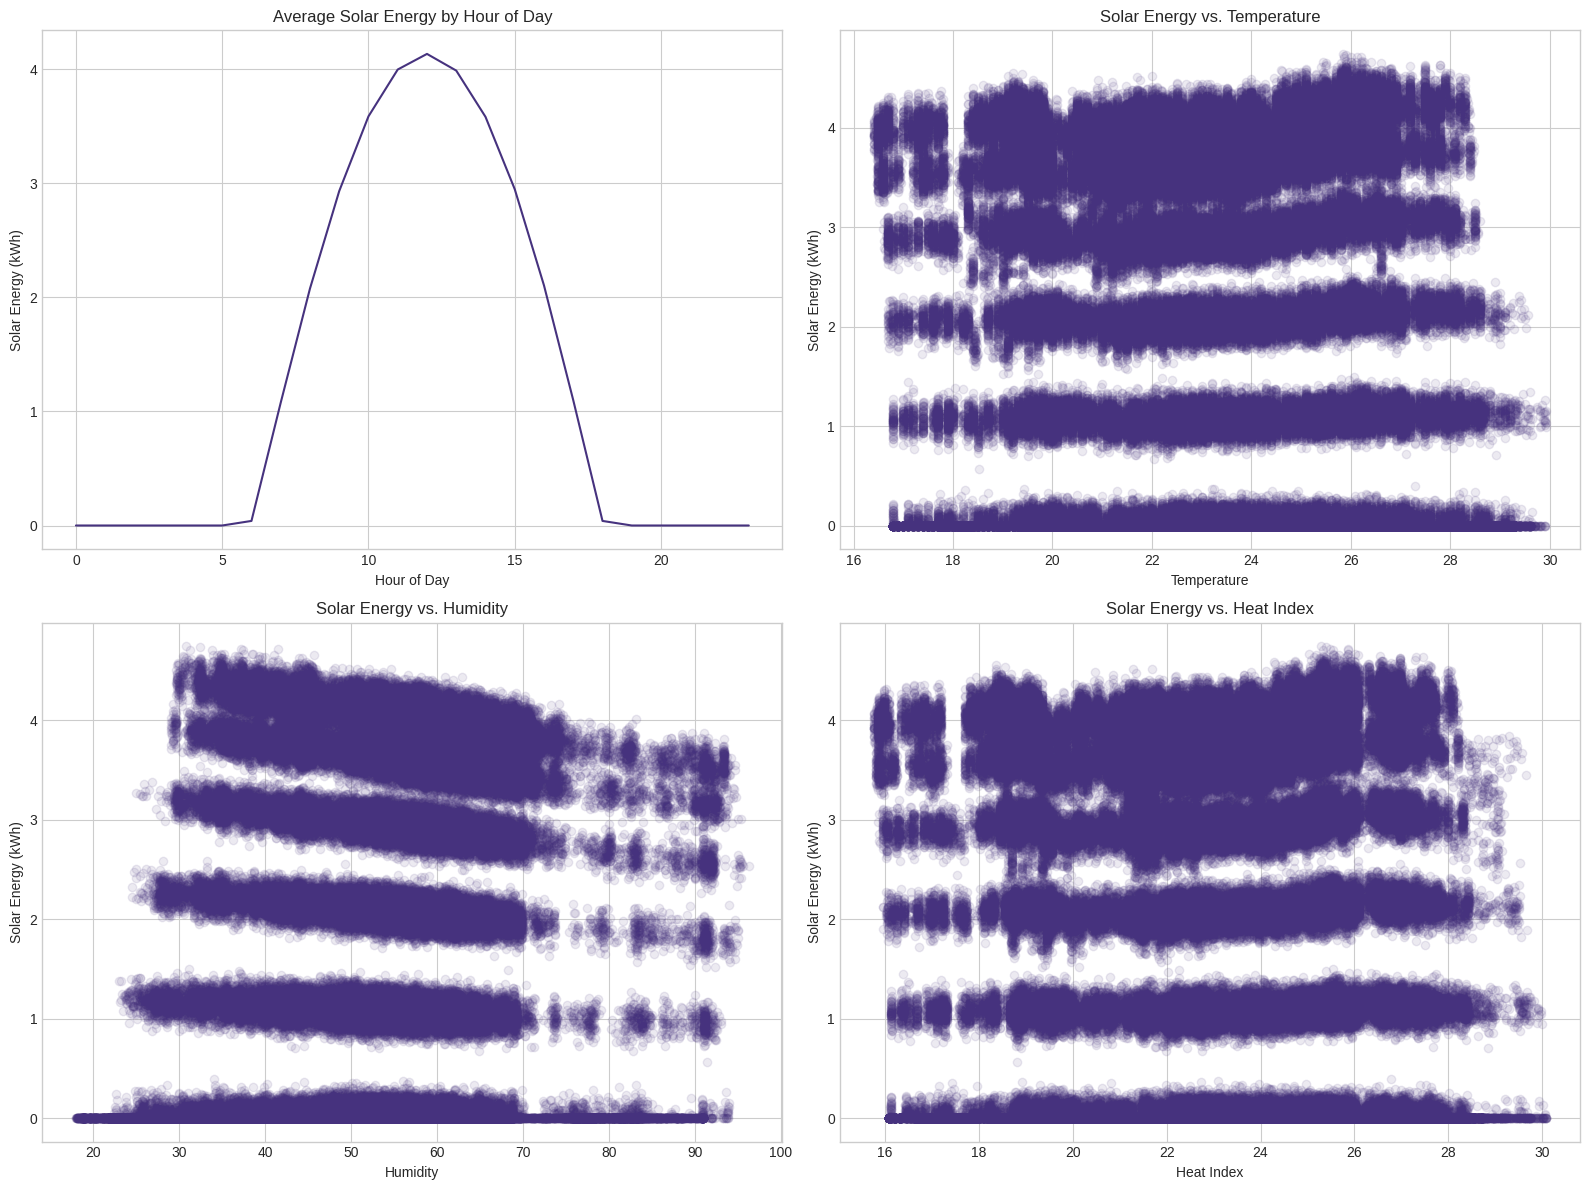


Step 4: Preparing features for modeling
Training data shape: (308697, 6)
Testing data shape: (77175, 6)

Step 5: Training and evaluating models

Training Linear Regression...
Linear Regression - RMSE: 1.0393, R²: 0.5804

Training Random Forest...
Random Forest - RMSE: 0.0791, R²: 0.9976

Training Gradient Boosting...
Gradient Boosting - RMSE: 0.0719, R²: 0.9980

Training XGBoost...
XGBoost - RMSE: 0.0704, R²: 0.9981

Best performing model: XGBoost with RMSE: 0.0704


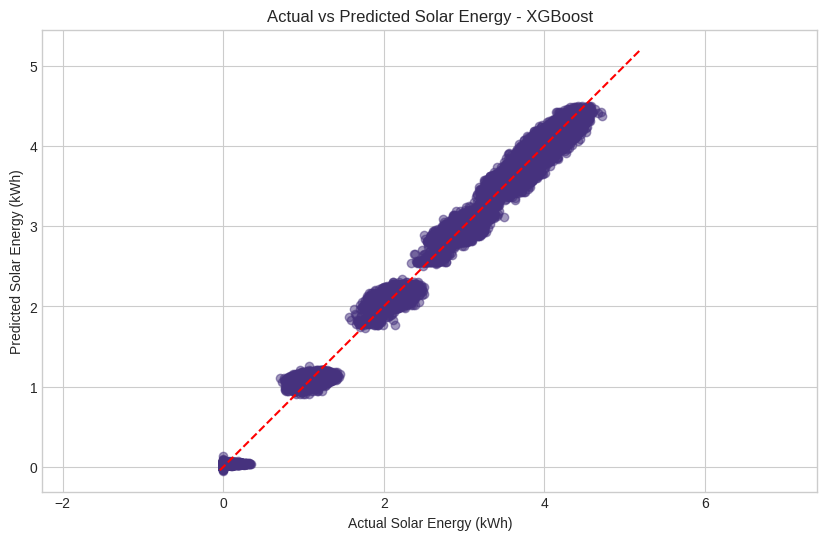

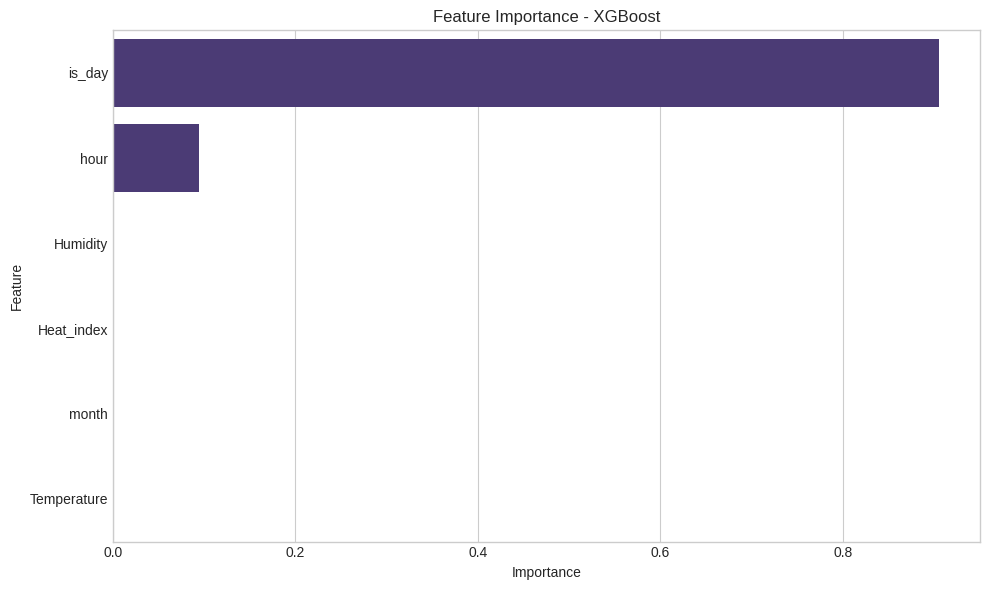


Feature importance:
is_day: 0.9051
hour: 0.0946
Humidity: 0.0003
Heat_index: 0.0000
month: 0.0000
Temperature: 0.0000

Model saved as 'solar_energy_prediction_model.joblib'

Example prediction:
For Temperature=25.0, Humidity=60.0, Heat Index=27.0, Hour=12, Month=6
Predicted Solar Energy: 4.18 kWh

=== Solar Energy Prediction Tool ===
Enter temperature: 14
Enter humidity: 40.11111
Enter heat index: 31.55
Enter hour of day (0-23): 08
Enter month (1-12): 3

Predicted Solar Energy: 2.39 kWh


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from datetime import datetime
import warnings
from google.colab import files
import io

# Ignore warnings
warnings.filterwarnings('ignore')

# Set the style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

print("Step 1: Upload your Sensors_data.csv file")
df = pd.read_csv('Sensors_data.csv')

# Data Exploration and Preprocessing
print("\nStep 2: Exploring and preprocessing the data")

# Display basic information about the dataset
print("\nDataset information:")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("\nFirst few rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Convert _time column to datetime
if '_time' in df.columns:
    df['_time'] = pd.to_datetime(df['_time'])

    # Extract time features
    df['hour'] = df['_time'].dt.hour
    df['day'] = df['_time'].dt.day
    df['month'] = df['_time'].dt.month
    df['dayofweek'] = df['_time'].dt.dayofweek
    df['is_day'] = ((df['hour'] >= 6) & (df['hour'] <= 18)).astype(int)

# Create a synthetic solar energy output based on the available features
# This is a simplified model based on known physics:
# - Higher temperature generally increases potential solar energy
# - High humidity can decrease efficiency
# - Daylight hours are when solar energy is generated
# - Maximum energy production typically occurs around noon

print("\nStep 3: Creating a model for solar energy prediction")

# Create a theoretical maximum power output (kW) assuming ideal conditions
max_power = 5.0  # Assume a 5kW system

# Create a synthetic solar energy output column (in kWh)
# Solar energy is only produced during daylight hours
df['solar_energy'] = 0.0

# Calculate solar energy based on:
# - Time of day (peak at noon)
# - Temperature (higher temp, slightly less efficiency)
# - Humidity (higher humidity, less energy)
# - Only produce energy during day hours

day_mask = df['hour'].between(6, 18)
df.loc[day_mask, 'solar_energy'] = (
    max_power *                                                  # Base max power
    np.sin(np.pi * (df.loc[day_mask, 'hour'] - 6) / 12) *       # Time of day factor (peak at noon)
    (1 - 0.005 * np.maximum(0, df.loc[day_mask, 'Temperature'] - 25)) *  # Temperature factor (reduced efficiency when hot)
    (1 - 0.003 * df.loc[day_mask, 'Humidity'])                   # Humidity factor (reduced in humid conditions)
)

# Add some realistic noise to the data
np.random.seed(42)
df.loc[day_mask, 'solar_energy'] += np.random.normal(0, 0.1, size=day_mask.sum())

# Ensure all values are positive
df['solar_energy'] = np.maximum(0, df['solar_energy'])

# Display the created energy data
print("\nSynthetic solar energy output statistics:")
print(df['solar_energy'].describe())

# Drop rows where we have NaNs
df = df.dropna()

# Plot the relationship between features and solar energy
plt.figure(figsize=(16, 12))

# Plot 1: Solar energy vs. Hour
plt.subplot(2, 2, 1)
hour_energy = df.groupby('hour')['solar_energy'].mean()
plt.plot(hour_energy.index, hour_energy.values)
plt.title('Average Solar Energy by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Solar Energy (kWh)')

# Plot 2: Solar energy vs. Temperature
plt.subplot(2, 2, 2)
plt.scatter(df['Temperature'], df['solar_energy'], alpha=0.1)
plt.title('Solar Energy vs. Temperature')
plt.xlabel('Temperature')
plt.ylabel('Solar Energy (kWh)')

# Plot 3: Solar energy vs. Humidity
plt.subplot(2, 2, 3)
plt.scatter(df['Humidity'], df['solar_energy'], alpha=0.1)
plt.title('Solar Energy vs. Humidity')
plt.xlabel('Humidity')
plt.ylabel('Solar Energy (kWh)')

# Plot 4: Solar energy vs. Heat_index
plt.subplot(2, 2, 4)
plt.scatter(df['Heat_index'], df['solar_energy'], alpha=0.1)
plt.title('Solar Energy vs. Heat Index')
plt.xlabel('Heat Index')
plt.ylabel('Solar Energy (kWh)')

plt.tight_layout()
plt.savefig('feature_relationships.png')
plt.show()

# Feature preparation for modeling
print("\nStep 4: Preparing features for modeling")

# Select features
features = ['hour', 'Temperature', 'Humidity', 'Heat_index', 'month', 'is_day']
X = df[features]
y = df['solar_energy']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Model Training and Evaluation
print("\nStep 5: Training and evaluating models")

# Initialize models to try
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"{name} - RMSE: {rmse:.4f}, R²: {r2:.4f}")

    # Store results
    results[name] = {
        'model': model,
        'rmse': rmse,
        'r2': r2,
        'predictions': y_pred
    }

# Find the best model
best_model_name = min(results, key=lambda k: results[k]['rmse'])
best_model = results[best_model_name]['model']
print(f"\nBest performing model: {best_model_name} with RMSE: {results[best_model_name]['rmse']:.4f}")

# Visualize predictions vs actual for the best model
plt.figure(figsize=(10, 6))
y_pred_best = results[best_model_name]['predictions']

# Calculate the upper and lower range for the plot
max_val = max(max(y_test), max(y_pred_best)) * 1.1
min_val = min(min(y_test), min(y_pred_best)) * 0.9

# Plot the actual vs predicted values
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title(f'Actual vs Predicted Solar Energy - {best_model_name}')
plt.xlabel('Actual Solar Energy (kWh)')
plt.ylabel('Predicted Solar Energy (kWh)')
plt.axis('equal')
plt.grid(True)
plt.savefig('prediction_results.png')
plt.show()

# Feature importance for the best model (if available)
if best_model_name in ["Random Forest", "Gradient Boosting", "XGBoost"]:
    plt.figure(figsize=(10, 6))

    if hasattr(best_model, 'feature_importances_'):
        # Get feature importances
        importances = best_model.feature_importances_

        # Create a DataFrame for easier plotting
        importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
        importance_df = importance_df.sort_values('Importance', ascending=False)

        # Plot
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(f'Feature Importance - {best_model_name}')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        plt.show()

        print("\nFeature importance:")
        for feature, importance in zip(importance_df['Feature'], importance_df['Importance']):
            print(f"{feature}: {importance:.4f}")

# Save the best model
import joblib
joblib.dump(best_model, 'solar_energy_prediction_model.joblib')
print("\nModel saved as 'solar_energy_prediction_model.joblib'")

# Create a function for making predictions with new data
def predict_solar_energy(temperature, humidity, heat_index, hour, month, is_day=None):
    """
    Predict solar energy production based on input parameters

    Parameters:
    temperature (float): Temperature in the same units as training data
    humidity (float): Humidity in the same units as training data
    heat_index (float): Heat index in the same units as training data
    hour (int): Hour of the day (0-23)
    month (int): Month of the year (1-12)
    is_day (int, optional): 1 if it's daytime, 0 if not. If None, calculated from hour

    Returns:
    float: Predicted solar energy production in kWh
    """
    if is_day is None:
        is_day = 1 if (hour >= 6 and hour <= 18) else 0

    # Create a DataFrame with the input values
    input_data = pd.DataFrame({
        'hour': [hour],
        'Temperature': [temperature],
        'Humidity': [humidity],
        'Heat_index': [heat_index],
        'month': [month],
        'is_day': [is_day]
    })

    # Make prediction
    prediction = best_model.predict(input_data)[0]

    # Ensure prediction is non-negative
    prediction = max(0, prediction)

    return prediction

# Example usage
print("\nExample prediction:")
example_temp = 25.0
example_humidity = 60.0
example_heat_index = 27.0
example_hour = 12
example_month = 6

predicted_energy = predict_solar_energy(
    temperature=example_temp,
    humidity=example_humidity,
    heat_index=example_heat_index,
    hour=example_hour,
    month=example_month
)

print(f"For Temperature={example_temp}, Humidity={example_humidity}, Heat Index={example_heat_index}, Hour={example_hour}, Month={example_month}")
print(f"Predicted Solar Energy: {predicted_energy:.2f} kWh")

# Interactive prediction function for Google Colab
def interactive_prediction():
    print("\n=== Solar Energy Prediction Tool ===")

    try:
        temperature = float(input("Enter temperature: "))
        humidity = float(input("Enter humidity: "))
        heat_index = float(input("Enter heat index: "))
        hour = int(input("Enter hour of day (0-23): "))
        month = int(input("Enter month (1-12): "))

        prediction = predict_solar_energy(temperature, humidity, heat_index, hour, month)
        print(f"\nPredicted Solar Energy: {prediction:.2f} kWh")

    except ValueError:
        print("Invalid input. Please enter numeric values.")

    print("=" * 35)

# Uncomment the line below to use the interactive prediction tool
interactive_prediction()
